#### H&M Personalized Fashion Recommendations W/ PySpark
#### Data Preprocessing + EDA
#### Last Updated: April 21, 2022
<br>

#### Overview

This notebook prepares data made available from the H&M Personalized Fashion Recommendation Competition (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data) for analyses performed in the model_building.ipynb notebook. 

First the transactions_full dataset is split into two dataframes, one comprising of purchases made before 8/1/2020 (named "tx_TrainTest"), and then other on or after 8/1/2020 (named "tx_val"). As the naming suggests, the former file is used for train / test, and the later for validation. These two files are used as the basis for subsequent data processing to prepare for market basket analysis, ALS analysis, and others. 

The note book also contains basic EDA and corresponding graphs.
<br>

#### Output File Description

<ins>For Market Basket Analysis (MBA)</ins>: 

train_mba_par: A parquet export of a transformed version of the "tx_TrainTest" dataframe, which is specifically formatted for input into the FPGrowth.fit() function. Used to train MBA model. <br>
val_mba_par: A parquet export used for calculating performance (based on MAP@12) of the MBA model. Based on unique list of customers from "tx_val".

<ins>For All Other Analyses</ins>

TrainTest_par: A parquet export of the "tx_TrainTest" dataframe <br>
val_par: A parquet export of the "tx_val" dataframe <br>


<br>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import collect_set, col, count, row_number, lit
from pyspark.sql.window import Window
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import from_unixtime, unix_timestamp, year, month, col, date_format

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "100g") \
    .appName('my-cool-app') \
    .getOrCreate()


In [2]:
os.chdir('/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Code')

<br>

#### Load Raw Datasets

Downloaded directly from https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data

Note that images were not used

In [5]:
customers = spark.read.csv('/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/raw_data/customers.csv',  inferSchema=True, header = True)
articles = spark.read.csv('/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/raw_data/articles.csv',  inferSchema=True, header = True)
transactions_full = spark.read.csv('/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/raw_data/transactions_train.csv',  inferSchema=True, header = True)

In [6]:
customers.show(5)

+--------------------+----+------+------------------+----------------------+---+--------------------+
|         customer_id|  FN|Active|club_member_status|fashion_news_frequency|age|         postal_code|
+--------------------+----+------+------------------+----------------------+---+--------------------+
|00000dbacae5abe5e...|null|  null|            ACTIVE|                  NONE| 49|52043ee2162cf5aa7...|
|0000423b00ade9141...|null|  null|            ACTIVE|                  NONE| 25|2973abc54daa8a5f8...|
|000058a12d5b43e67...|null|  null|            ACTIVE|                  NONE| 24|64f17e6a330a85798...|
|00005ca1c9ed5f514...|null|  null|            ACTIVE|                  NONE| 54|5d36574f52495e81f...|
|00006413d8573cd20...| 1.0|   1.0|            ACTIVE|             Regularly| 52|25fa5ddee9aac01b3...|
+--------------------+----+------+------------------+----------------------+---+--------------------+
only showing top 5 rows



In [8]:
articles.show(1)

+----------+------------+---------+---------------+-----------------+------------------+-----------------------+-------------------------+-----------------+-----------------+-------------------------+---------------------------+--------------------------+----------------------------+-------------+---------------+----------+----------+--------------+----------------+----------+--------------------+----------------+------------------+--------------------+
|article_id|product_code|prod_name|product_type_no|product_type_name|product_group_name|graphical_appearance_no|graphical_appearance_name|colour_group_code|colour_group_name|perceived_colour_value_id|perceived_colour_value_name|perceived_colour_master_id|perceived_colour_master_name|department_no|department_name|index_code|index_name|index_group_no|index_group_name|section_no|        section_name|garment_group_no|garment_group_name|         detail_desc|
+----------+------------+---------+---------------+-----------------+---------------

In [9]:
transactions_full.show(5)

+----------+--------------------+----------+--------------------+----------------+
|     t_dat|         customer_id|article_id|               price|sales_channel_id|
+----------+--------------------+----------+--------------------+----------------+
|2018-09-20|000058a12d5b43e67...| 663713001|0.050830508474576264|               2|
|2018-09-20|000058a12d5b43e67...| 541518023| 0.03049152542372881|               2|
|2018-09-20|00007d2de826758b6...| 505221004| 0.01523728813559322|               2|
|2018-09-20|00007d2de826758b6...| 685687003|0.016932203389830508|               2|
|2018-09-20|00007d2de826758b6...| 685687004|0.016932203389830508|               2|
+----------+--------------------+----------+--------------------+----------------+
only showing top 5 rows



<br>

#### Create Lookup Table for Article Types

In [8]:
# Create distinct pairings of product types, and index

art_lookup = articles.select(col('product_type_name'), col('index_name')) \
                       .distinct() \
                       .sort(col('product_type_no'))


# Create ID for unique product, index types

w = Window().orderBy(lit('A'))
art_lookup = art_lookup.withColumn("prod_index_id", row_number().over(w))


# Rejoin with articles, extract relevant columns

art_lookup = articles.join(art_lookup, 
                           on = ['product_type_name', 'index_name'], 
                           how = 'inner')

art_lookup = art_lookup.select(col('article_id'),
                  col('product_type_name'), col('product_code'),
                  col('product_type_no'), 
                  col('index_name'), 
                  col('prod_index_id')).sort(col('prod_index_id'))

art_lookup_short = art_lookup.select(col('article_id'), 
                  col('prod_index_id')).sort(col('prod_index_id'))

In [9]:
# Small Lookup Table

art_lookup_short.show(5)

+----------+-------------+
|article_id|prod_index_id|
+----------+-------------+
| 519243001|            1|
| 919896001|            2|
| 894221001|            2|
| 902265001|            2|
| 902265002|            2|
+----------+-------------+
only showing top 5 rows



In [10]:
# See that shirts now have a unique ID for each index

art_lookup.select(col('product_type_name'), 
                col('product_type_no'), 
                col('index_name'), 
                col('prod_index_id')).distinct().sort(col('prod_index_id')).filter(col('product_type_name') == 'Shirt').show()

+-----------------+---------------+--------------------+-------------+
|product_type_name|product_type_no|          index_name|prod_index_id|
+-----------------+---------------+--------------------+-------------+
|            Shirt|            259|Children Sizes 13...|          261|
|            Shirt|            259|    Baby Sizes 50-98|          262|
|            Shirt|            259|             Divided|          263|
|            Shirt|            259|Children Sizes 92...|          264|
|            Shirt|            259|          Ladieswear|          265|
|            Shirt|            259|            Menswear|          266|
|            Shirt|            259|Children Accessor...|          267|
+-----------------+---------------+--------------------+-------------+



<br>

#### Preprocessing For Generic Train / Test / Validation sets. 

##### Additional transormations will be done downstream to prepare data for respective analyses. 

##### To keep customer transactions together as opposed to being divided across the train / test sets, the split shall be based on rownumber after the data is sorted on the customer_id

In [5]:
transactions_full = transactions_full.sort(col('customer_id'))

In [6]:
transactions_full.createOrReplaceTempView("transactions_full")

In [11]:
tx_TrainTest = spark.sql("SELECT * FROM transactions_full WHERE t_dat <= '2020-07-31'")
tx_TrainTest = tx_TrainTest.join(art_lookup_short, on = 'article_id', how = 'inner')

In [12]:
tx_TrainTest.sort(col('customer_id')).show(5)

+----------+----------+--------------------+--------------------+----------------+-------------+
|article_id|     t_dat|         customer_id|               price|sales_channel_id|prod_index_id|
+----------+----------+--------------------+--------------------+----------------+-------------+
| 568601006|2019-05-25|00000dbacae5abe5e...|0.050830508474576264|               2|          299|
| 627759010|2018-12-27|00000dbacae5abe5e...| 0.03049152542372881|               1|          282|
| 795440001|2020-03-21|00000dbacae5abe5e...|0.014389830508474576|               2|          227|
| 785186005|2019-11-22|00000dbacae5abe5e...|0.016932203389830508|               2|          232|
| 607642008|2019-07-25|00000dbacae5abe5e...|0.012694915254237289|               1|          265|
+----------+----------+--------------------+--------------------+----------------+-------------+
only showing top 5 rows



In [15]:
# Tx_TrainTest is saved as a parquet to increase efficiency

tx_TrainTest.write.mode('overwrite').parquet("/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/processed_data/TrainTest_par")

##### Validation set will be created using transactions that occurred on / or after August 1, 2020

In [16]:
tx_val = spark.sql("SELECT * FROM transactions_full WHERE t_dat > '2020-07-31'")
tx_val = tx_val.join(art_lookup_short, on = 'article_id', how = 'inner')

In [17]:
tx_val.sort(col('customer_id')).show(5)

+----------+----------+--------------------+--------------------+----------------+-------------+
|article_id|     t_dat|         customer_id|               price|sales_channel_id|prod_index_id|
+----------+----------+--------------------+--------------------+----------------+-------------+
| 568601043|2020-09-05|00000dbacae5abe5e...|0.050830508474576264|               1|          299|
| 794321007|2020-09-15|000058a12d5b43e67...|0.061000000000000006|               2|          283|
| 896152002|2020-08-12|00006413d8573cd20...|0.027101694915254236|               2|          238|
| 927530004|2020-08-12|00006413d8573cd20...| 0.04744067796610169|               2|          304|
| 791587015|2020-08-12|00006413d8573cd20...|0.020322033898305086|               2|          241|
+----------+----------+--------------------+--------------------+----------------+-------------+
only showing top 5 rows



In [18]:
# Tx_Val is saved as a parquet to increase efficiency

tx_val.write.mode('overwrite').parquet("/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/processed_data/val_par")

<br>

#### Additional Processing for MBA

##### Create training baskets by customer_id. Note that MBA analysis does not need a test set, so entire TrainTest_par will be treated as training data. 

In [59]:
parquetFile = spark.read.parquet("/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/processed_data/TrainTest_par")
parquetFile.createOrReplaceTempView("train_mba")

In [60]:
train_mba = spark.sql("SELECT * FROM train_mba")

train_mba = train_mba.groupBy('customer_id') \
                      .agg(collect_set('article_id') \
                      .alias('items'))

In [61]:
train_mba.show(10)

+--------------------+--------------------+
|         customer_id|               items|
+--------------------+--------------------+
|000346516dd355b40...|[507909001, 64243...|
|0003e56a4332b2503...|         [682520002]|
|0011a72ff27917972...|[782555006, 22460...|
|0022058e10f379f15...|         [846581002]|
|0028449d82fdf6771...|         [649437002]|
|0037dbd391c8b1535...|[568601006, 50415...|
|00387918f3d005323...|         [325087044]|
|0038bf2b66fdc1de4...|[849859002, 84126...|
|003a91c7ac71487cf...|[791571001, 82978...|
|004432f08708cc499...|[832362003, 88794...|
+--------------------+--------------------+
only showing top 10 rows



In [62]:
train_mba.write.mode('overwrite').parquet("/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/processed_data/train_mba_par")

##### Create validation set for MBA. This is accomplished by finding the purchase history of customers in the val_par dataset, and then joining the tables

In [45]:
# Get MBA validation data from parquet file (previously created)

parquetFile = spark.read.parquet("/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/processed_data/val_par")
parquetFile.createOrReplaceTempView("val_mba")

val_mba = spark.sql("SELECT * FROM val_mba")

In [46]:
# Create baskets of items from validation set (transactions on / after August 1, 2020)

val_short = spark.sql("SELECT article_id, customer_id FROM val_mba")

val_new_baskets = val_short.groupBy('customer_id') \
                      .agg(collect_set('article_id') \
                      .alias('labels'))

# Create a list of customers that made purchases on or after August 1, 2020

customer_val = val_mba.select(col('customer_id')).distinct()

# Join the customer list onto the tx_TrainTest dataset
# Purpose: Filter to only transactions with these customers

val_history = tx_TrainTest.join(customer_val, on = 'customer_id', how = 'leftsemi')

val_hist_baskets = val_history.groupBy('customer_id') \
                      .agg(collect_set('article_id') \
                      .alias('history'))

# Merge val_new_baskets and val_hist_baskets

val_mba_final = val_new_baskets.join(val_hist_baskets, on = 'customer_id', how = 'inner')

val_mba_final.show(5)


+--------------------+--------------------+--------------------+
|         customer_id|              labels|             history|
+--------------------+--------------------+--------------------+
|0038bf2b66fdc1de4...|[864415002, 89475...|[849859002, 54736...|
|004432f08708cc499...|[933406001, 85078...|[832362003, 88794...|
|005ddabf9bc77f963...|[745232001, 91381...|[803080001, 22825...|
|006ae0656ded2215d...|[803083002, 85001...|[720100001, 75790...|
|0086f22a4967559a6...|[828295001, 87131...|[443262015, 75671...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [47]:
val_mba_final.write.mode('overwrite').parquet("/sfs/qumulo/qhome/sar2jf/Documents/hm_fashion/Data/processed_data/val_mba_par")

<br>

#### Exploratory Data Analysis

In [13]:
tx_TrainTest.show(5)

+----------+----------+--------------------+--------------------+----------------+-------------+
|article_id|     t_dat|         customer_id|               price|sales_channel_id|prod_index_id|
+----------+----------+--------------------+--------------------+----------------+-------------+
| 126589006|2018-09-20|416e1246ddc942aa2...|0.005067796610169492|               1|           66|
| 126589006|2018-09-20|5467e41baa5c8d241...|0.005067796610169492|               1|           66|
| 126589006|2018-09-20|a7343a4f0dc5c0081...|0.005067796610169492|               1|           66|
| 126589006|2018-09-21|1c8e361209fcfae24...|0.005067796610169492|               1|           66|
| 126589006|2018-09-21|2fcd9f6ab161e9d03...|0.005067796610169492|               1|           66|
+----------+----------+--------------------+--------------------+----------------+-------------+
only showing top 5 rows



In [22]:
# Get counts of product type by month

TrainTest_small = tx_TrainTest.select(col('t_dat'), col('prod_index_id'))
TrainTest_small = TrainTest_small.withColumn("t_month", TrainTest_small.t_dat.substr(1,7))
TrainTest_small = TrainTest_small.groupby('t_month', 'prod_index_id').count()

TrainTest_small.show(5)

+-------+-------------+-----+
|t_month|prod_index_id|count|
+-------+-------------+-----+
|2019-04|          439| 4899|
|2018-09|          341| 1143|
|2019-02|          122|  517|
|2020-04|          289| 8965|
|2020-04|          433|  877|
+-------+-------------+-----+
only showing top 5 rows



##### Most Popular Product Types

In [15]:
pop_prod = TrainTest_small.groupby('prod_index_id').sum('count').orderBy(col('sum(count)').desc())

pop_prod.show(5)

+-------------+----------+
|prod_index_id|sum(count)|
+-------------+----------+
|          304|   1983854|
|          334|   1961430|
|          216|   1549708|
|          333|   1488598|
|          258|   1216056|
+-------------+----------+
only showing top 5 rows



In [24]:
TrainTest_pd = TrainTest_small.toPandas()
pop_prod_pd = pop_prod.toPandas()

##### Sales by Product Type by Month

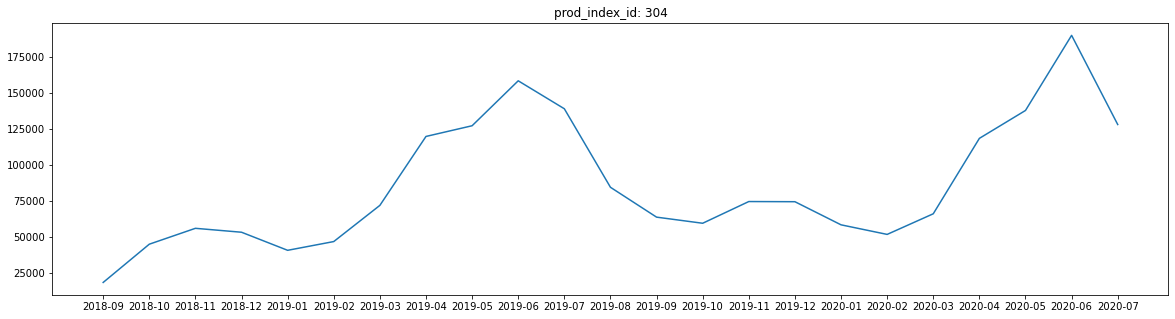

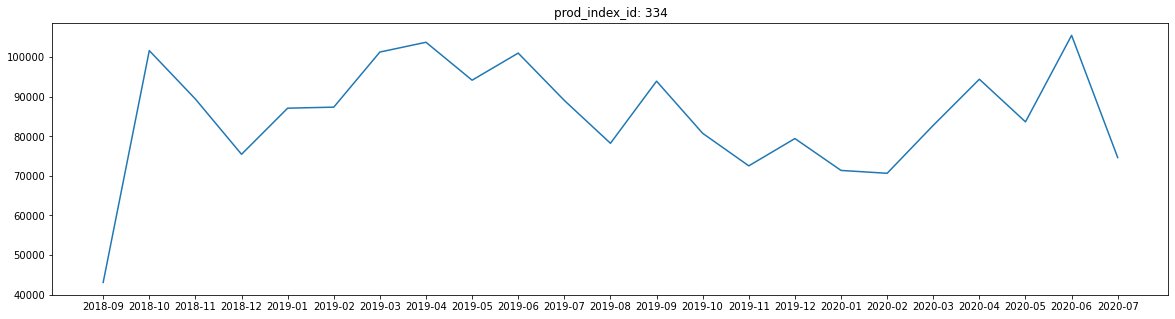

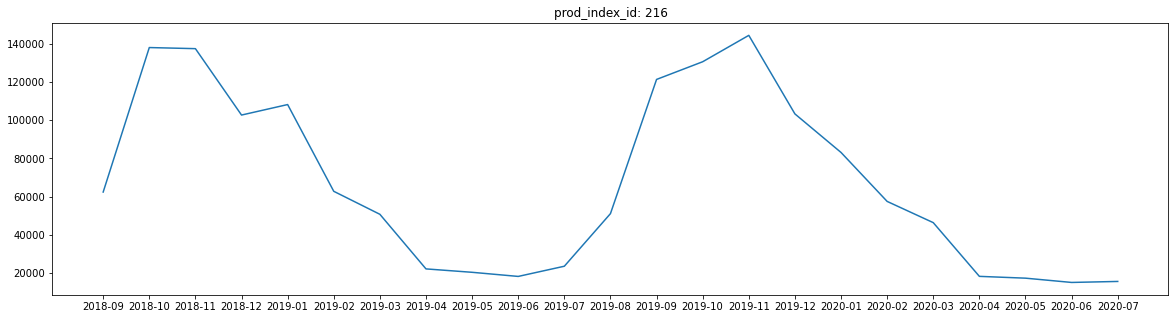

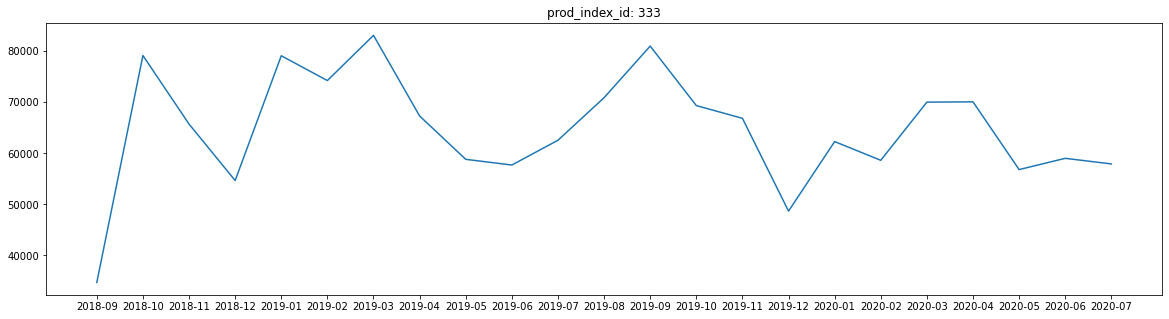

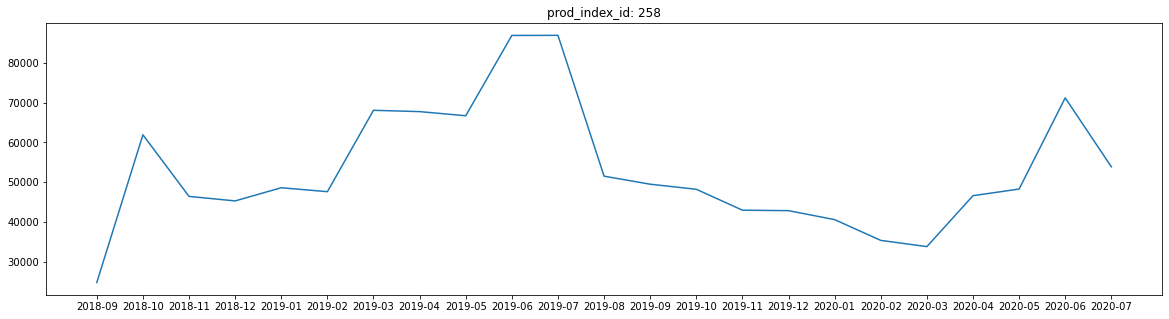

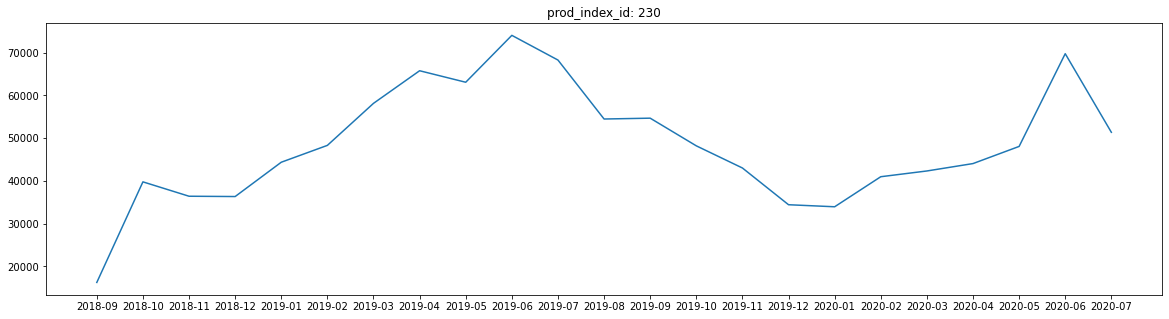

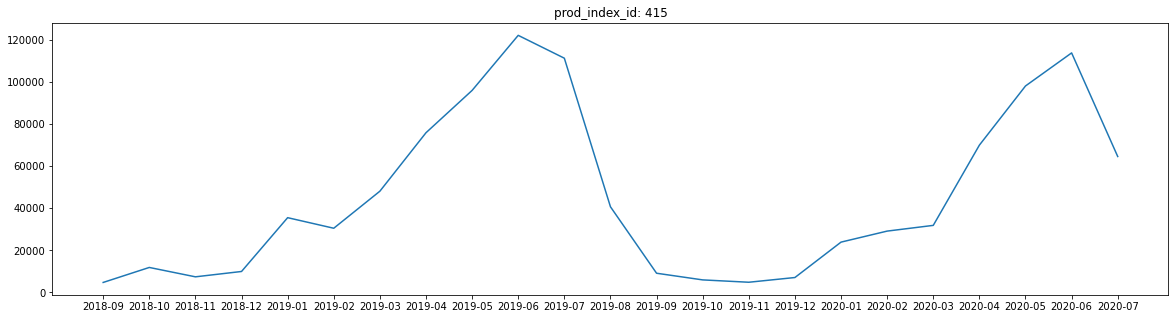

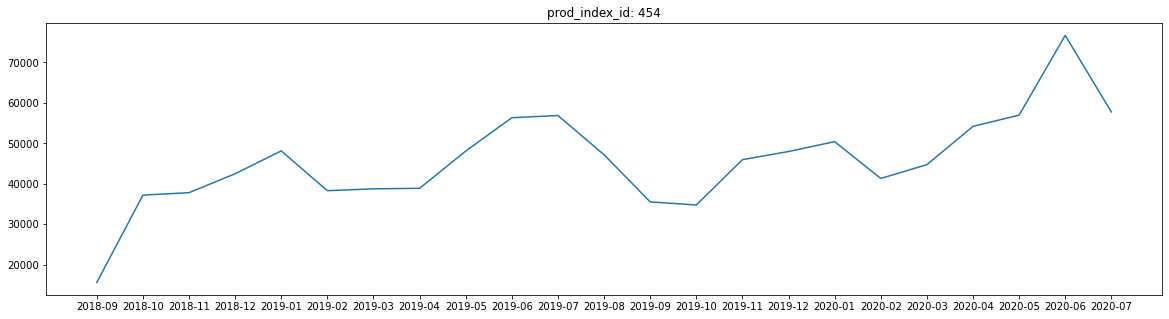

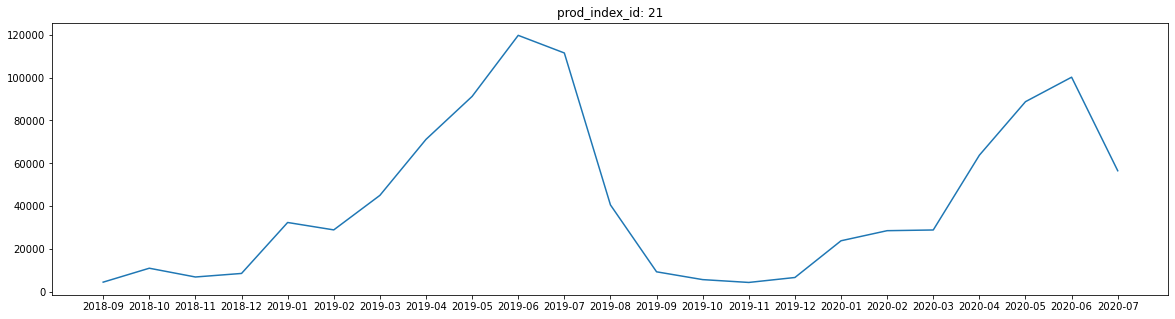

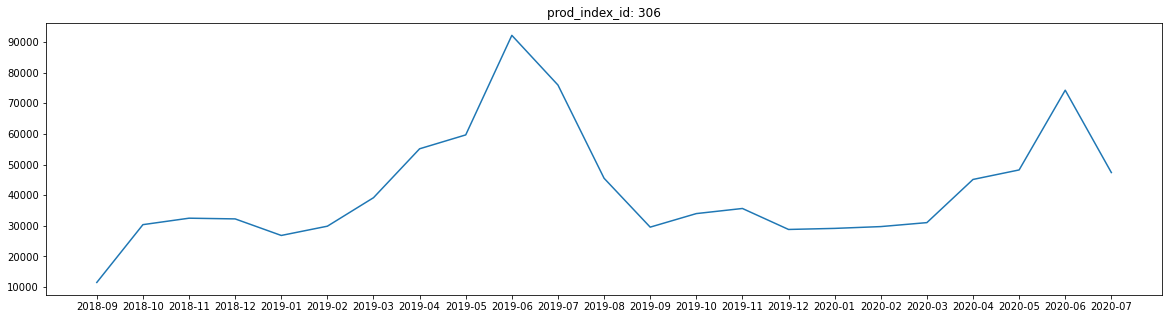

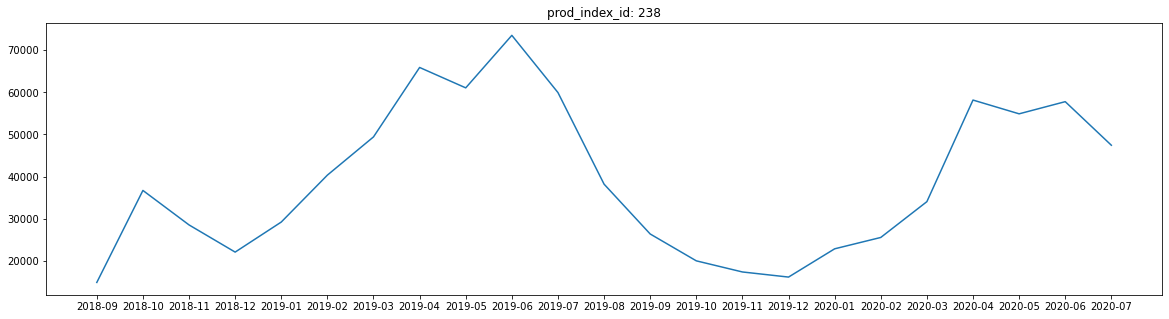

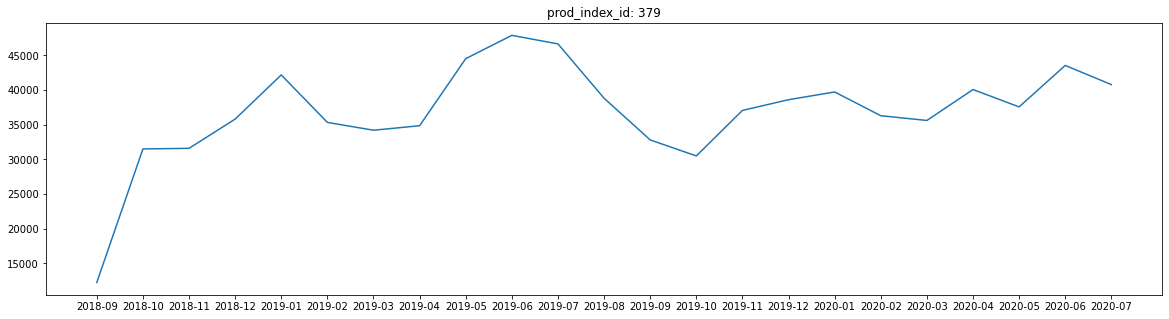

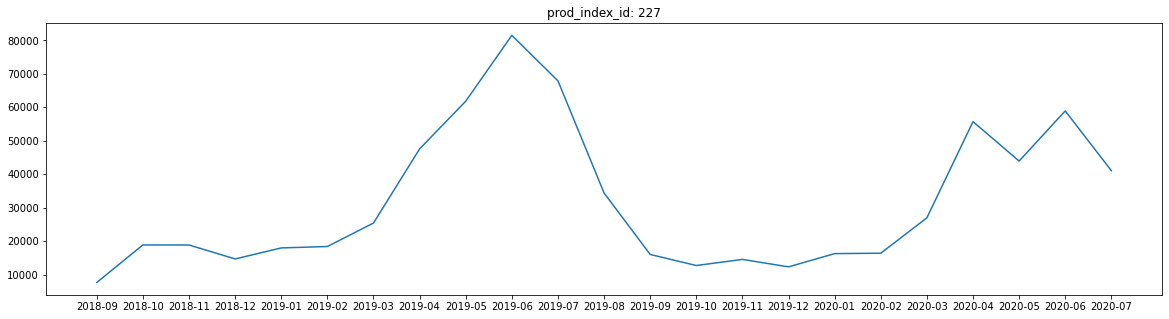

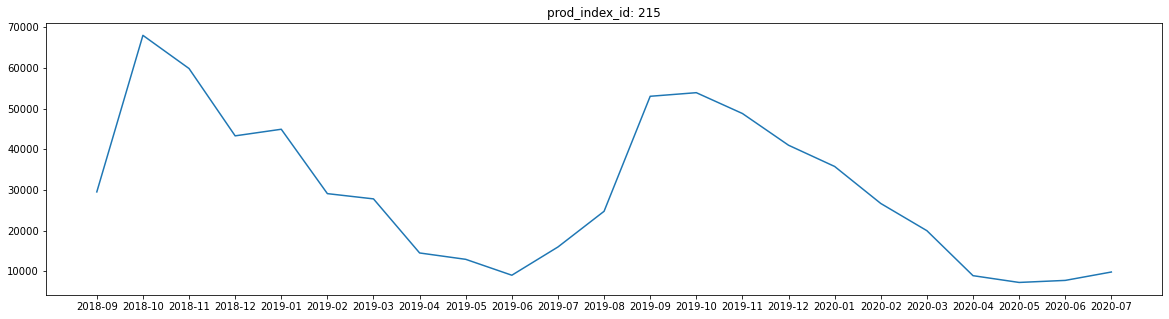

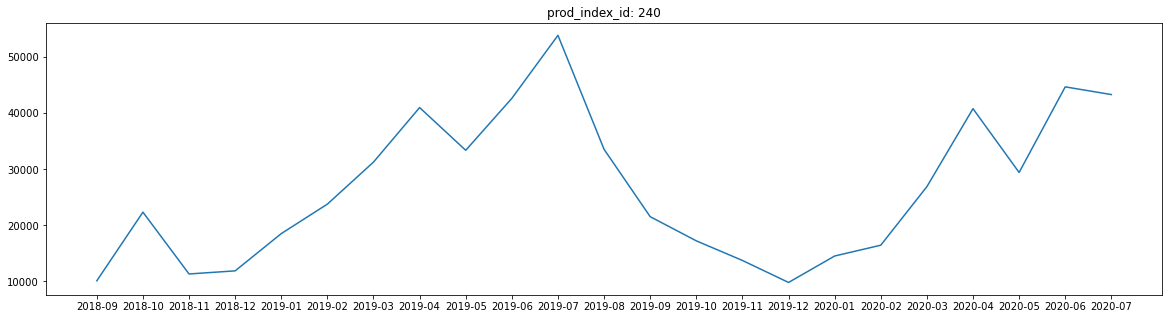

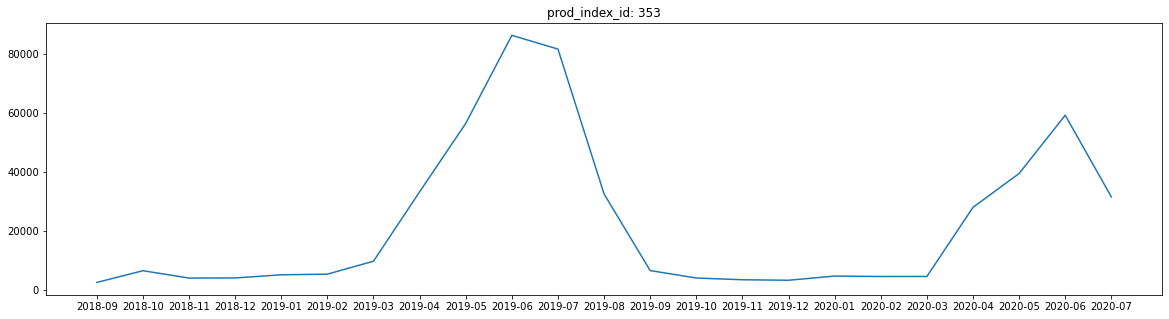

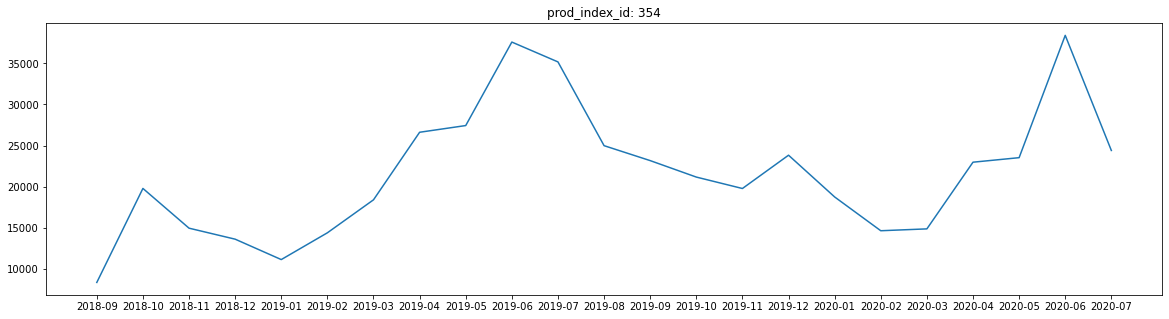

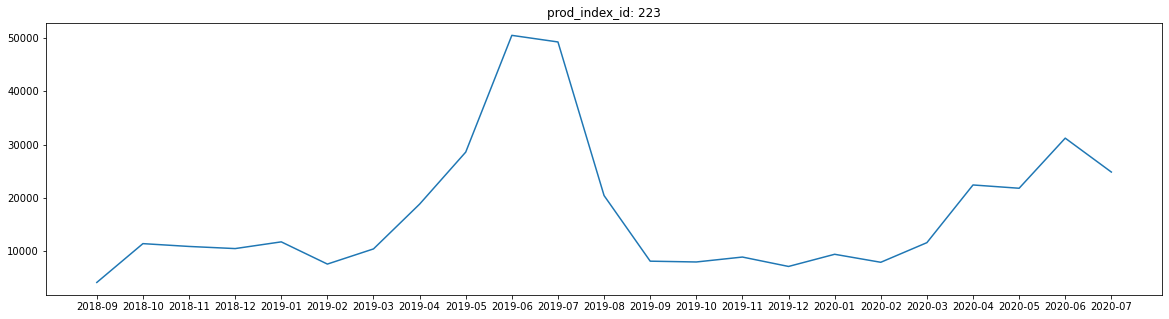

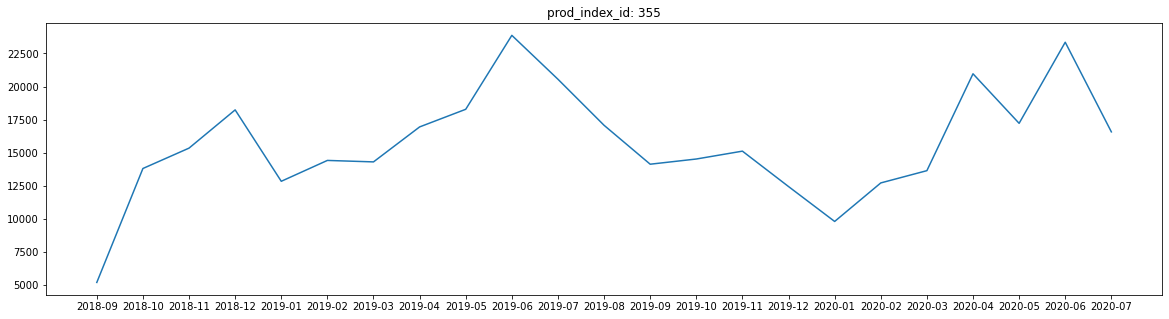

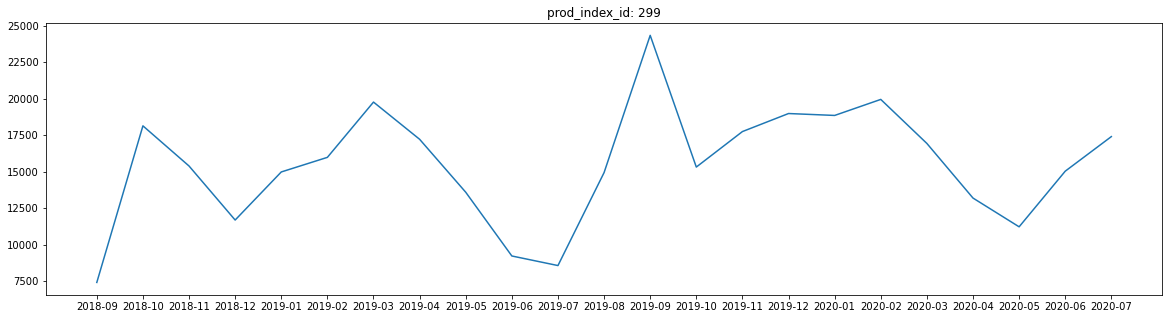

In [42]:
%matplotlib inline
from matplotlib.pyplot import figure

# Plot sales of most popular top product over time

for i in range(20): 
    
    prod_index_id = int(pop_prod_pd['prod_index_id'][i])
        
    temp_df = TrainTest_pd.loc[TrainTest_pd['prod_index_id'] == prod_index_id, ['t_month', 'count']].sort_values(by = 't_month')
    
    x = temp_df['t_month']
    y = temp_df['count']
    
    figure(figsize=(20, 5))
    plt.plot(x, y)
    plt.title('prod_index_id: ' + str(prod_index_id))
    